In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import rdkit
import os 

import matplotlib.pyplot as plt

from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (LeaveOneOut, cross_val_predict,
                                     cross_val_score, train_test_split)

import numpy as np 
import re

from rdkit.Chem import Descriptors
#print(len(Descriptors._descList))
#print(Descriptors._descList[:5])
#print(rdkit.__version__)

from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

# build correlation matrix for the descriptors
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_top_correlations_blog(df, threshold=0.4):
    """
    df: the dataframe to get correlations from
    threshold: the maximum and minimum value to include for correlations. For eg, if this is 0.4, only pairs haveing a correlation coefficient greater than 0.4 or less than -0.4 will be included in the results. 
    """
    orig_corr = df.corr()
    c = orig_corr.abs()

    so = c.unstack()

    #print("|    Variable 1    |    Variable 2    | Correlation Coefficient    |")
    #print("|------------------|------------------|----------------------------|")
    
    #i=0
    pairs=set()
    result = []
    for index, value in so.sort_values(ascending=False).items():
        # Exclude duplicates and self-correlations
        if value > threshold \
        and index[0] != index[1] \
        and (index[0], index[1]) not in pairs \
        and (index[1], index[0]) not in pairs:
            
            #print(f'|    {index[0]}    |    {index[1]}    |    {orig_corr.loc[(index[0], index[1])]}    |')
            #result.loc[i, ['Variable 1', 'Variable 2', 'Correlation Coefficient']] = \
            #    [index[0], index[1], orig_corr.loc[(index[0], index[1])]]
            result.append([index[0], index[1], orig_corr.loc[(index[0], index[1])]])
            pairs.add((index[0], index[1]))
            #i+=1
            
    #return result.reset_index(drop=True).set_index(['Variable 1', 'Variable 2'])
    return result

@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

DEfine basic data structures and config

In [2]:
# those are the output data
molnames = []
labels = []
diffs_toothermethods = []
chemical_reacts = []
stechio_ceofs = []
moldescriptors = []

howmanydifs = 3
rootdirqdata = './qdata/'
rootdirdata = './data/'

hflist = ["Nuclear Repulsion  :", \
          "One Electron Energy:", \
          "Two Electron Energy:", \
          "Potential Energy   :", \
          "Kinetic Energy     :", \
          "Dispersion correction", \
          "Total Charge", \
          "Multiplicity", \
          "Number of Electrons", \
          "FINAL SINGLE POINT ENERGY"]

pbelist = ["Nuclear Repulsion  :", \
            "One Electron Energy:", \
            "Two Electron Energy:", \
            "Potential Energy   :", \
            "Kinetic Energy     :", \
            "E(X)               :"  , \
            "E(C)               :"  , \
            "Dispersion correction", \
            "Total Charge"   , \
            "Multiplicity"   , \
            "Number of Electrons", \
            "FINAL SINGLE POINT ENERGY"]


Read molecules labels and more

In [3]:

fp = open(rootdirdata + '/labels.txt', 'r')

for line in fp:
    sline = line.replace("\t", " ").replace("\n", "").rstrip().lstrip().split()
    molname = sline[1]
    
    difvals = []   
    for i in range(howmanydifs):
        difvals.append(float(sline[-1*(i+1)]))

    schechio = []
    reacts = []
    for i in range(2,len(sline)-howmanydifs-1):
        nospace = sline[i].replace(" ", "")
        if nospace.isdigit():
            schechio.append(int(nospace))
        elif nospace.startswith("-") and nospace[1:].isdigit():
            schechio.append(int(nospace))
        else:
            reacts.append(nospace)

    stechio_ceofs.append(schechio)
    chemical_reacts.append(reacts)
    diffs_toothermethods.append(difvals)
    labels.append(float(sline[-1*howmanydifs-1]))
    molnames.append(molname)
    moldescriptors.append({})

fp.close()

print("")
print("Number of labels         :", len(labels))
print("Number of names          :", len(molnames))
print("Number of differences    :", len(diffs_toothermethods))
print("Number of chemicals      :", len(chemical_reacts))
print("Number of stechio ceofs  :", len(stechio_ceofs))
print("Number of moldescriptors :", len(moldescriptors))


Number of labels         : 140
Number of names          : 140
Number of differences    : 140
Number of chemicals      : 140
Number of stechio ceofs  : 140
Number of moldescriptors : 140


Read PBE data

In [4]:
pbedescriptor = {}

for file in os.listdir(rootdirqdata+'/PBE/'):
    if file.endswith('.out'):
        molname = file.split('.out')[0]
        molname = re.split("\.mpi\d+", molname)[0]
        #print(molname)
        moldesc = {}
        fp = open(rootdirqdata+'/PBE/'+file, 'r')
        for line in fp:
            for val in pbelist:
                if line.find(val) != -1:
                    keyval = val.replace(":", "").rstrip().lstrip().replace(" ", "_")
                    sline = line.rstrip().lstrip().split()
                    for sval in sline:
                        try:
                            firstnumvalue = float(sval)
                            break
                        except:
                            continue
                    
                    moldesc["PBE_"+keyval] = firstnumvalue
                    #print(molname, keyval, sval)
        fp.close()
        pbedescriptor[molname] = moldesc

for i, molname in enumerate(molnames):
    if molname in pbedescriptor:
        for k in pbedescriptor[molname].keys():
            moldescriptors[i][k] = pbedescriptor[molname][k]
    else:
        print(molname + " not found in PBE descriptors")

print("")
print("Number of labels         :", len(labels))
print("Number of names          :", len(molnames))
print("Number of differences    :", len(diffs_toothermethods))
print("Number of chemicals      :", len(chemical_reacts))
print("Number of stechio ceofs  :", len(stechio_ceofs))
print("Number of moldescriptors :", len(moldescriptors))


Number of labels         : 140
Number of names          : 140
Number of differences    : 140
Number of chemicals      : 140
Number of stechio ceofs  : 140
Number of moldescriptors : 140


Read HF data

In [5]:
hfdescriptor = {}

for file in os.listdir(rootdirqdata+'/HF/'):
    if file.endswith('.out'):
        molname = file.split('.out')[0]
        molname = re.split("\.mpi\d+", molname)[0]
        #print(molname)
        moldesc = {}
        fp = open(rootdirqdata+'/HF/'+file, 'r')
        for line in fp:
            for val in hflist:
                if line.find(val) != -1:
                    keyval = val.replace(":", "").rstrip().lstrip().replace(" ", "_")
                    sline = line.rstrip().lstrip().split()
                    for sval in sline:
                        try:
                            firstnumvalue = float(sval)
                            break
                        except:
                            continue
                    
                    moldesc["HF_"+keyval] = firstnumvalue
                    #print(molname, keyval, sval)
        fp.close()
        hfdescriptor[molname] = moldesc

for i, molname in enumerate(molnames):
    if molname in pbedescriptor:
        for k in hfdescriptor[molname].keys():
            moldescriptors[i][k] = hfdescriptor[molname][k]
    else:
        print(molname + " not found in HF descriptors")


print("")
print("Number of labels         :", len(labels))
print("Number of names          :", len(molnames))
print("Number of differences    :", len(diffs_toothermethods))
print("Number of chemicals      :", len(chemical_reacts))
print("Number of stechio ceofs  :", len(stechio_ceofs))
print("Number of moldescriptors :", len(moldescriptors))


Number of labels         : 140
Number of names          : 140
Number of differences    : 140
Number of chemicals      : 140
Number of stechio ceofs  : 140
Number of moldescriptors : 140


Remove molecules with some missing descriptor

In [6]:
alldims = set([len(val) for val in moldescriptors])
idxtoremovs = []
for i, val in enumerate(moldescriptors):
    if len(val) != max(alldims):
        idxtoremovs.append(i)

for i in sorted(idxtoremovs, reverse=True):
    print("Molname to remove:", molnames[i], "index:", i)
    del moldescriptors[i]
    del labels[i]
    del molnames[i]
    del diffs_toothermethods[i]
    del chemical_reacts[i]
    del stechio_ceofs[i]

print("")
print("Number of labels         :", len(labels))
print("Number of names          :", len(molnames))
print("Number of differences    :", len(diffs_toothermethods))
print("Number of chemicals      :", len(chemical_reacts))
print("Number of stechio ceofs  :", len(stechio_ceofs))
print("Number of moldescriptors :", len(moldescriptors))


Number of labels         : 140
Number of names          : 140
Number of differences    : 140
Number of chemicals      : 140
Number of stechio ceofs  : 140
Number of moldescriptors : 140


Remove molecules with None Label 

In [7]:
for i, v in enumerate(labels):
    if v is None:
        print("None value found in labels:", i, molnames[i])
        del moldescriptors[i]
        del labels[i]
        del molnames[i]
        del diffs_toothermethods[i]
        del chemical_reacts[i]
        del stechio_ceofs[i]

print("")
print("Number of labels         :", len(labels))
print("Number of names          :", len(molnames))
print("Number of differences    :", len(diffs_toothermethods))
print("Number of chemicals      :", len(chemical_reacts))
print("Number of stechio ceofs  :", len(stechio_ceofs))
print("Number of moldescriptors :", len(moldescriptors))


Number of labels         : 140
Number of names          : 140
Number of differences    : 140
Number of chemicals      : 140
Number of stechio ceofs  : 140
Number of moldescriptors : 140


If a descriptor is nan at least for a molecule remove from all

In [8]:
import math 

nandescriptors = set()
for index, molname in enumerate(molnames):
    if any(math.isnan(val) for val in moldescriptors[index].values()):
        print("Nan value found in descriptors:", molname)
        for k,v in moldescriptors[index].items():
            if math.isnan(v):
                nandescriptors.add(k)

print("Removing the following Descriptors ", nandescriptors)
print("Removing ", len(nandescriptors), " descriptors")
for i, v in enumerate(moldescriptors):
    for k in nandescriptors:
        del moldescriptors[i][k]


print("")
print("Number of descriptors:", len(moldescriptors[0]))
print("")
print("Number of labels         :", len(labels))
print("Number of names          :", len(molnames))
print("Number of differences    :", len(diffs_toothermethods))
print("Number of chemicals      :", len(chemical_reacts))
print("Number of stechio ceofs  :", len(stechio_ceofs))
print("Number of moldescriptors :", len(moldescriptors))

Removing the following Descriptors  set()
Removing  0  descriptors

Number of descriptors: 22

Number of labels         : 140
Number of names          : 140
Number of differences    : 140
Number of chemicals      : 140
Number of stechio ceofs  : 140
Number of moldescriptors : 140


Read chemicals

In [9]:
chemicals_descriptors = {}

for v in chemical_reacts:
    for chem in v:

        moldesc = {}
        fp = open(rootdirqdata + '/PBE/'+chem+'.out', 'r')
        for line in fp:
            for val in pbelist:
                if line.find(val) != -1:
                    keyval = val.replace(":", "").rstrip().lstrip().replace(" ", "_")
                    sline = line.rstrip().lstrip().split()
                    for sval in sline:
                        try:
                            firstnumvalue = float(sval)
                            break
                        except:
                            continue
                    
                    moldesc["PBE_"+keyval] = firstnumvalue

        fp.close

        fp = open(rootdirqdata + '/HF/'+chem+'.out', 'r')
        for line in fp:
            for val in hflist:
                if line.find(val) != -1:
                    keyval = val.replace(":", "").rstrip().lstrip().replace(" ", "_")
                    sline = line.rstrip().lstrip().split()
                    for sval in sline:
                        try:
                            firstnumvalue = float(sval)
                            break
                        except:
                            continue
                    
                    moldesc["HF_"+keyval] = firstnumvalue
        fp.close()

        chemicals_descriptors[chem] = moldesc

print("")
print("Number of chemicals descriptors:", len(chemicals_descriptors))


Number of chemicals descriptors: 12


Check error respect to QM methods

In [10]:

for methodid in range(howmanydifs):
    y_pred = []
    for i, molname in enumerate(molnames):
        y_pred.append(labels[i] + diffs_toothermethods[i][methodid])

    # plot a scatterplot of the true vs predicted values
    #plt.figure(figsize=(10,10))
    #plt.scatter(labels, y_pred, c='crimson')
    #plt.xlabel('True')
    #plt.ylabel('Predicted Values')
    
    print("Method", methodid+1, "R2 score  :", r2_score(labels, y_pred))
    print("Method", methodid+1, "RMSE score:", mean_squared_error(labels, y_pred, squared=False))

y_pred = []
autokcalmol = 627.5096080305927
for mi, molname in enumerate(molnames):
    #print(molname)
    oury = moldescriptors[mi]["PBE_FINAL_SINGLE_POINT_ENERGY"]
    si = 1
    tosub = 0.0
    for ci, chem in enumerate(chemical_reacts[mi]):
        stecchio = stechio_ceofs[mi][si]
        tosub += stecchio*chemicals_descriptors[chem]["PBE_FINAL_SINGLE_POINT_ENERGY"]
        si += 1
        
    y_pred.append(autokcalmol*(tosub-oury))
    #print(molname, oury, tosub, 627.51* (tosub-oury), labels[mi])

# plot a scatterplot of the true vs predicted values
#plt.figure(figsize=(10,10))
#plt.scatter(labels, y_pred, c='crimson')
#plt.xlabel('True')
#plt.ylabel('Predicted Values')

print("Our Method R2 score  :", r2_score(labels, y_pred))
print("Our Method RMSE score:", mean_squared_error(labels, y_pred, squared=False))  
     

Method 1 R2 score  : 0.9899437365837602
Method 1 RMSE score: 19.259720069171752
Method 2 R2 score  : 0.9905892336475421
Method 2 RMSE score: 18.631342333360124
Method 3 R2 score  : 0.990716922542401
Method 3 RMSE score: 18.50451203664354
Our Method R2 score  : 0.9228150294408229
Our Method RMSE score: 53.3578131123409


Build PBE differences

In [11]:
pbe_diff_descriptors = []

# here I can remove PBE_Nuclear_Repulsion but I will keep it to be general
pbeenergylist = ["PBE_Nuclear_Repulsion", \
            "PBE_One_Electron_Energy", \
            "PBE_Two_Electron_Energy", \
            "PBE_Potential_Energy", \
            "PBE_Kinetic_Energy", \
            "PBE_E(X)"  , \
            "PBE_E(C)"  , \
            "PBE_Dispersion_correction", \
            "PBE_FINAL_SINGLE_POINT_ENERGY"]

pbenonenergylist = ["PBE_Total_Charge", \
            "PBE_Multiplicity", \
            "PBE_Number_of_Electrons"]

for mi, molname in enumerate(molnames):
    diff_desc = {}
    for desc in pbeenergylist:
        y = moldescriptors[mi][desc]
        si = 1
        comp = 0.0
        for ci, chem in enumerate(chemical_reacts[mi]):
            stecchio = stechio_ceofs[mi][si]
            comp += stecchio*chemicals_descriptors[chem][desc]
            si += 1
        
        diff_desc[desc] = comp-y

    for desc in pbenonenergylist:
        diff_desc[desc] = moldescriptors[mi][desc]
    
    pbe_diff_descriptors.append(diff_desc)

print("")
print("Number of labels               :", len(labels))
print("Number of names                :", len(molnames))
print("Number of differences          :", len(diffs_toothermethods))
print("Number of chemicals            :", len(chemical_reacts))
print("Number of stechio ceofs        :", len(stechio_ceofs))
print("Number of moldescriptors       :", len(moldescriptors))
print("Number of pbe_diff_descriptors :", len(pbe_diff_descriptors))


Number of labels               : 140
Number of names                : 140
Number of differences          : 140
Number of chemicals            : 140
Number of stechio ceofs        : 140
Number of moldescriptors       : 140
Number of pbe_diff_descriptors : 140


Build features matrix

In [12]:
moldescriptors_featues = []
Y = []
features_names = []

for idx, molname in enumerate(molnames):
    val = []
    for k,v in pbe_diff_descriptors[idx].items():
        if idx == 0:
            features_names.append(k)
        val.append(v)
    moldescriptors_featues.append(val)
    Y.append(labels[idx])

Y = np.array(Y)
moldescriptors_featues = np.array(moldescriptors_featues)
#print(features_names)

df = pd.DataFrame(moldescriptors_featues, columns=features_names)

top_corr = get_top_correlations_blog(df, 0.8)
for tc in top_corr:
    print(tc)

['PBE_One_Electron_Energy', 'PBE_Nuclear_Repulsion', -0.99995447781551]
['PBE_One_Electron_Energy', 'PBE_Two_Electron_Energy', -0.9999407994582038]
['PBE_Nuclear_Repulsion', 'PBE_Two_Electron_Energy', 0.9998097065964346]
['PBE_Kinetic_Energy', 'PBE_Potential_Energy', -0.9605490247076963]
['PBE_Two_Electron_Energy', 'PBE_Number_of_Electrons', -0.9432897843451706]
['PBE_Number_of_Electrons', 'PBE_One_Electron_Energy', 0.942935267597019]
['PBE_Number_of_Electrons', 'PBE_Nuclear_Repulsion', -0.9428313063575217]
['PBE_E(C)', 'PBE_FINAL_SINGLE_POINT_ENERGY', 0.8923305535267234]
['PBE_E(C)', 'PBE_Kinetic_Energy', 0.8854406834038481]
['PBE_FINAL_SINGLE_POINT_ENERGY', 'PBE_Kinetic_Energy', 0.8125143160960776]


Build PLS model using alla features

2023-11-18 19:14:16.430685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-18 19:14:16.430701: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/redo/anaconda3/envs/myrdkit/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(13) should be in [1, n_features].n_components=12 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/home/redo/anaconda3/envs/myrdkit/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(14) should be in [1, n_features].n_components=12 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


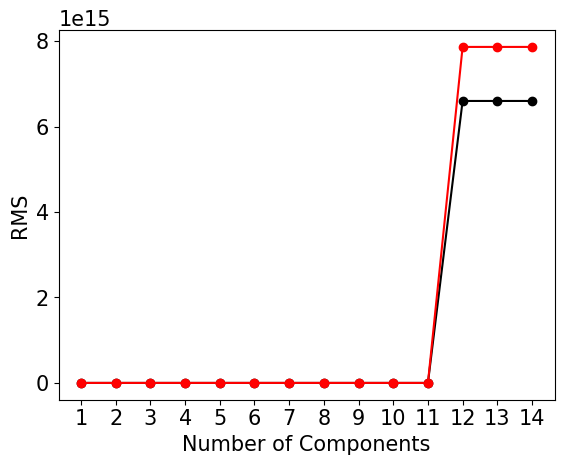

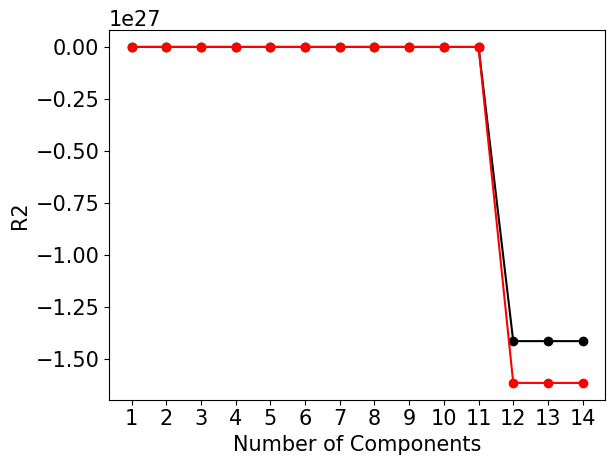

Max R2 Test set:  0.991137250514601  N. Comps:  11
Min RMSE Test set:  16.529255282118516  N. Comps:  11
RMSE Train:  13.345976949115844
RMSE Test :  16.529255282118516
R2 Train  :  0.995353055816515
R2 Test   :  0.991137250514601
RMSE Full:  14.040489187252478
R2 Full  :  0.9946555726418774


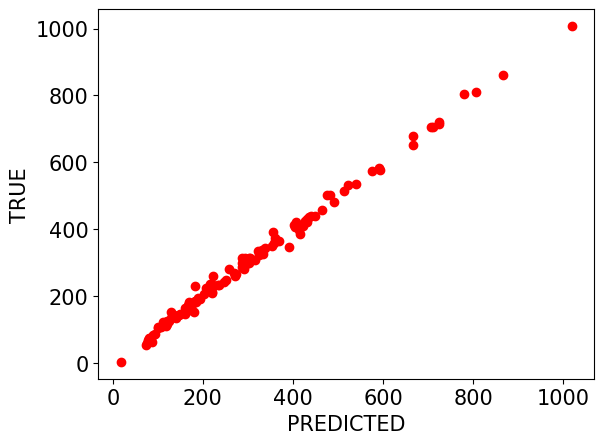

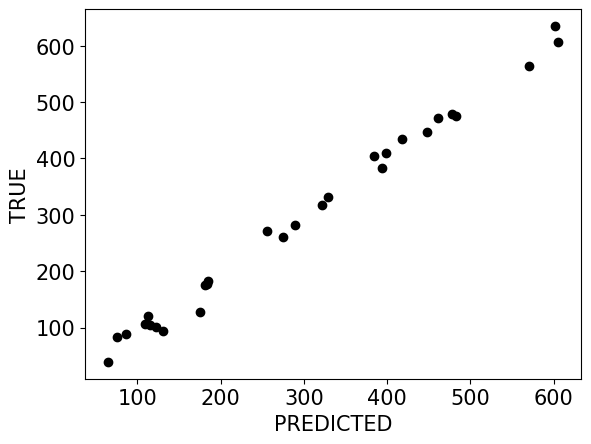

RMSE:  15.774965302641693


In [13]:
import models
%reload_ext models

perc_split = 0.2
ncomps, rmses_test, rmses_train, r2s_test, r2s_train = \
    models.pls_model (0.2, moldescriptors_featues, Y)

r2max_comps = np.argmax(r2s_test)+1
rmsemin_comps = np.argmin(rmses_test)+1
print("Max R2 Test set: ", np.max(r2s_test), " N. Comps: ", r2max_comps)
print("Min RMSE Test set: ", np.min(rmses_test), " N. Comps: ", rmsemin_comps)

compstouse = min(rmsemin_comps, r2max_comps)
models.pls_model (0.2, moldescriptors_featues, Y, False, compstouse)

perc_split = 0.0
models.pls_model (perc_split, moldescriptors_featues, Y, False, compstouse, leaveoneout=True)

Not considering the Non energy desc

In [14]:
pbe_diff_descriptors = []

# here I can remove PBE_Nuclear_Repulsion but I will keep it to be general
pbeenergylist = ["PBE_Nuclear_Repulsion", \
            "PBE_One_Electron_Energy", \
            "PBE_Two_Electron_Energy", \
            "PBE_Potential_Energy", \
            "PBE_Kinetic_Energy", \
            "PBE_E(X)"  , \
            "PBE_E(C)"  , \
            "PBE_Dispersion_correction", \
            "PBE_FINAL_SINGLE_POINT_ENERGY"]

for mi, molname in enumerate(molnames):
    diff_desc = {}
    for desc in pbeenergylist:
        y = moldescriptors[mi][desc]
        si = 1
        comp = 0.0
        for ci, chem in enumerate(chemical_reacts[mi]):
            stecchio = stechio_ceofs[mi][si]
            comp += stecchio*chemicals_descriptors[chem][desc]
            si += 1
        
        diff_desc[desc] = comp-y
    
    pbe_diff_descriptors.append(diff_desc)

print("")
print("Number of labels               :", len(labels))
print("Number of names                :", len(molnames))
print("Number of differences          :", len(diffs_toothermethods))
print("Number of chemicals            :", len(chemical_reacts))
print("Number of stechio ceofs        :", len(stechio_ceofs))
print("Number of moldescriptors       :", len(moldescriptors))
print("Number of pbe_diff_descriptors :", len(pbe_diff_descriptors))


Number of labels               : 140
Number of names                : 140
Number of differences          : 140
Number of chemicals            : 140
Number of stechio ceofs        : 140
Number of moldescriptors       : 140
Number of pbe_diff_descriptors : 140


In [15]:
moldescriptors_featues = []
Y = []
features_names = []

for idx, molname in enumerate(molnames):
    val = []
    for k,v in pbe_diff_descriptors[idx].items():
        if idx == 0:
            features_names.append(k)
        val.append(v)
    moldescriptors_featues.append(val)
    Y.append(labels[idx])

Y = np.array(Y)
moldescriptors_featues = np.array(moldescriptors_featues)
#print(features_names)

df = pd.DataFrame(moldescriptors_featues, columns=features_names)

top_corr = get_top_correlations_blog(df, 0.8)
for tc in top_corr:
    print(tc)

['PBE_One_Electron_Energy', 'PBE_Nuclear_Repulsion', -0.99995447781551]
['PBE_One_Electron_Energy', 'PBE_Two_Electron_Energy', -0.9999407994582038]
['PBE_Nuclear_Repulsion', 'PBE_Two_Electron_Energy', 0.9998097065964346]
['PBE_Potential_Energy', 'PBE_Kinetic_Energy', -0.9605490247076963]
['PBE_FINAL_SINGLE_POINT_ENERGY', 'PBE_E(C)', 0.8923305535267234]
['PBE_E(C)', 'PBE_Kinetic_Energy', 0.8854406834038481]
['PBE_FINAL_SINGLE_POINT_ENERGY', 'PBE_Kinetic_Energy', 0.8125143160960776]


/home/redo/anaconda3/envs/myrdkit/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(10) should be in [1, n_features].n_components=9 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/home/redo/anaconda3/envs/myrdkit/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(11) should be in [1, n_features].n_components=9 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/home/redo/anaconda3/envs/myrdkit/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(12) should be in [1, n_features].n_components=9 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/home/redo/anaconda3/envs/myrdkit/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: Fut

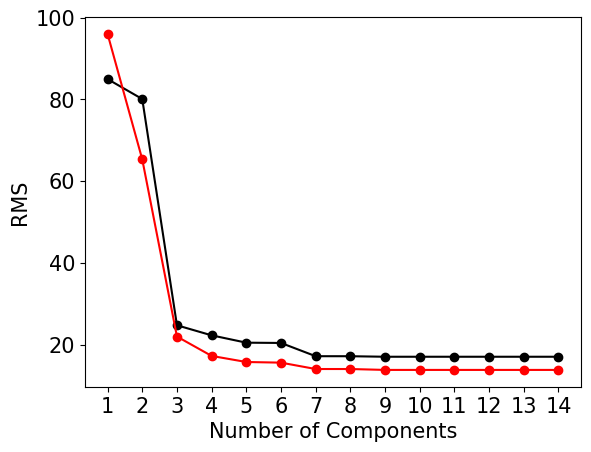

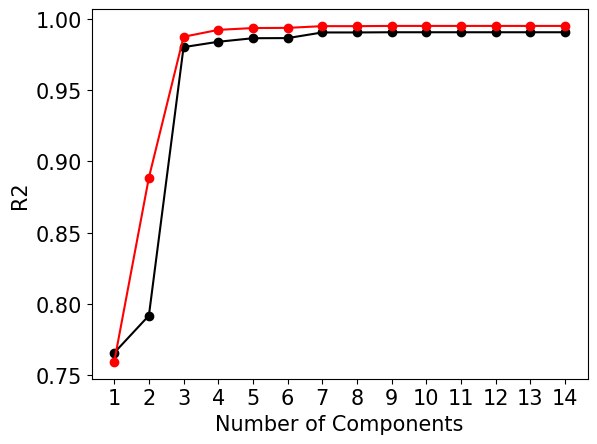

Max R2 Test set:  0.9905871760598016  N. Comps:  9
Min RMSE Test set:  17.034485386834895  N. Comps:  9
RMSE Train:  13.80944054653272
RMSE Test :  17.034485386834895
R2 Train  :  0.9950247044503004
R2 Test   :  0.9905871760598016
RMSE Full:  14.511900531819936
R2 Full  :  0.9942906681645354


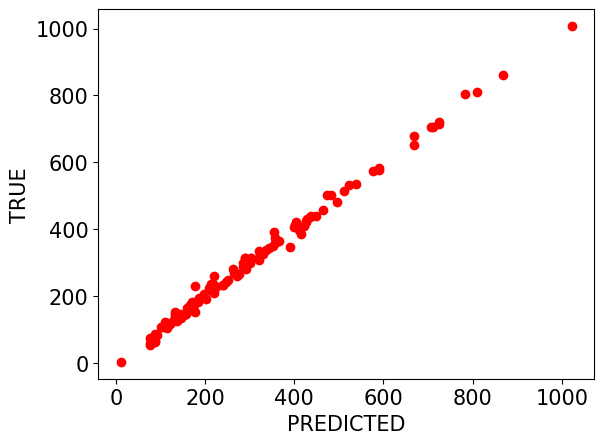

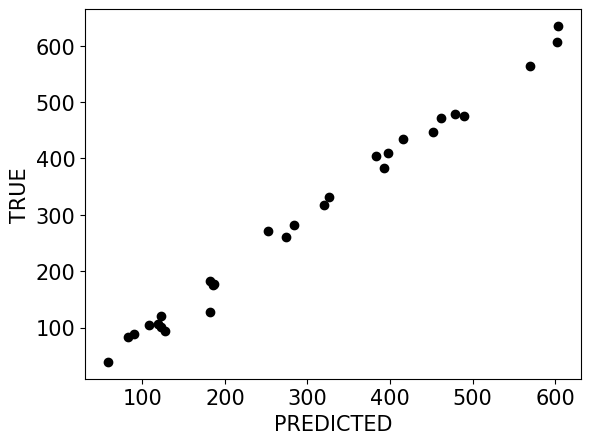

RMSE:  16.002136580183628


In [16]:
import models
%reload_ext models

perc_split = 0.2
ncomps, rmses_test, rmses_train, r2s_test, r2s_train = \
    models.pls_model (0.2, moldescriptors_featues, Y)

r2max_comps = np.argmax(r2s_test)+1
rmsemin_comps = np.argmin(rmses_test)+1
print("Max R2 Test set: ", np.max(r2s_test), " N. Comps: ", r2max_comps)
print("Min RMSE Test set: ", np.min(rmses_test), " N. Comps: ", rmsemin_comps)

compstouse = min(rmsemin_comps, r2max_comps)
models.pls_model (0.2, moldescriptors_featues, Y, False, compstouse)

perc_split = 0.0
models.pls_model (perc_split, moldescriptors_featues, Y, False, compstouse, leaveoneout=True)